<a href="https://colab.research.google.com/github/EcovisionSN/EcoVision_PAS_2023/blob/main/models/model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model EcoVision


## Preparing the environment

### Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, \
    MaxPool2D, UpSampling2D, concatenate, Input, Conv2DTranspose, MaxPooling2D, \
    Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import datetime
import copy
import PIL
import sys
import random
import os
from tqdm import tqdm
from matplotlib import colors
from matplotlib.colors import ListedColormap
import cv2
from numpy.random.mtrand import rand

from tensorflow.keras import backend as K
from scipy.ndimage import distance_transform_edt as distance

random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
print("TensorFlow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

TensorFlow version 2.12.0


### Connect GoogleDrive

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Defining model related code

### Loss functions and Metrics

In [4]:
class IOU(tf.keras.metrics.Metric):

  def __init__(self, name, C, **kwargs):
    super(IOU, self).__init__(name=name, **kwargs)
    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.C = C

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
    y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
    value = 0
    for index in range(self.C):
      intersection = tf.math.reduce_sum(tf.math.multiply(y_true[..., index], y_pred[..., index]))
      union = tf.math.reduce_sum(y_true[..., index]) + tf.math.reduce_sum(y_pred[..., index]) - intersection
      value += tf.math.reduce_sum((intersection + 1e-16) / (union + 1e-16))
    self.iou.assign_add(value / self.C)

  def reset_states(self):
    for s in self.variables:
      s.assign(tf.zeros(shape=s.shape))

  def result(self):
    return self.iou

In [5]:
class F1Score(tf.keras.metrics.Metric):

  def __init__(self, name, C, **kwargs):
    super(F1Score, self).__init__(name=name, **kwargs)
    self.f1score = self.add_weight(name='f1score', initializer='zeros')
    self.C = C

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
    y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
    value = 0
    for index in range(self.C):
      intersection = tf.math.reduce_sum(tf.math.multiply(y_true[..., index], y_pred[..., index]))
      union = tf.math.reduce_sum(y_true[..., index]) + tf.math.reduce_sum(y_pred[..., index])
      value += tf.math.reduce_sum((2. * intersection + 1e-16) / (union + 1e-16))
    self.f1score.assign_add(value / self.C)

  def reset_states(self):
    for s in self.variables:
      s.assign(tf.zeros(shape=s.shape))

  def result(self):
    return self.f1score

In [6]:
class BorderLoss(tf.keras.losses.Loss):
  def __init__(self, C : "Num of classes, third dimenstion",
               name="border_loss_function", reduction=tf.keras.losses.Reduction.NONE):
    super().__init__(reduction=reduction, name=name)
    self.C = C

  def calc_dist_map(self, seg):
      res = np.zeros_like(seg)
      posmask = seg.astype(np.bool)

      if posmask.any():
          negmask = ~posmask
          res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

      return res

  def calc_dist_map_batch(self, y_true):
      y_true_numpy = y_true.numpy()
      return np.array([self.calc_dist_map(y)
                      for y in y_true_numpy]).astype(np.float32)

  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    result_list = []
    for index in range(self.C):
      y_true_dist_map = self.calc_dist_map_batch(y_true[..., index])
      result = y_pred[..., index] * y_true_dist_map
      result_list.append(result)
    return tf.stack(result)

In [7]:
class HybridLoss(tf.keras.losses.Loss):
  def __init__(self, _lambda_, _alpha, _beta, smooth=1e-16, C=3, weights=[0.5, 2.0, 0.5],
               reduction=tf.keras.losses.Reduction.NONE,
               name='tversky_loss_function'):
    super().__init__(reduction=reduction, name=name)
    self._lambda_ = _lambda_
    self._alpha = _alpha
    self._beta = _beta
    self.smooth = smooth
    self.C = C
    self.weights = weights

  def tversky_loss(self, y_true, y_pred):
    y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
    y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
    tversky = []
    for index in range(self.C): # Class order: Forest, Deforest., Other.
        TP = tf.reduce_sum(tf.math.multiply(y_pred[..., index], y_true[..., index]), axis=1)
        FP = tf.reduce_sum(tf.math.multiply(y_pred[..., index], 1-y_true[..., index]), axis=1)
        FN = tf.reduce_sum(tf.math.multiply(1-y_pred[..., index], y_true[..., index]), axis=1)

        tversky_i = (TP + self.smooth) / (TP + self._alpha * FP + self._beta * FN + self.smooth)
        tversky.append(tversky_i * self.weights[index])
    return self.C - tf.stack(tversky)

  def dice_coef_multilabel(self, y_true, y_pred):
    y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
    y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
    dice = []
    for index in range(self.C):
      intersection = 2 * tf.reduce_sum(tf.math.multiply(y_pred[..., index], y_true[..., index]), axis=1)+ self.smooth
      denominator = tf.reduce_sum(tf.math.square(y_pred[..., index]) + tf.math.square(y_true[..., index]), axis=1)+ self.smooth
      dice_i = intersection / denominator
      dice.append(- dice_i)
    return self.C + tf.stack(dice)

  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    tversky = self.tversky_loss(y_true, y_pred)
    dice = self.dice_coef_multilabel(y_true, y_pred)
    result = tversky + self._lambda_ * dice
    #result = tf.reduce_sum(result)
    return result

### Dataset creation from TFRecords files

In [8]:
BATCH_SIZE = "8"
BATCH_SIZE = int(BATCH_SIZE)

VALIDATION_SPLIT = 0.5

GCS_PATTERN = "/content/gdrive/MyDrive/dataset/RECORDS/tfrecords_v2_part_*.tfrec"

filenames = tf.io.gfile.glob(GCS_PATTERN)
print(f"Available {len(filenames)} files.")
for i in filenames[:5]:
  print(i)
print()
random.shuffle(filenames)

split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
print(f"Validation filename: {validation_filenames}")
print(f"Training filename: {training_filenames}")
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE

print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Available 2 files.
/content/gdrive/MyDrive/dataset/RECORDS/tfrecords_v2_part_1.tfrec
/content/gdrive/MyDrive/dataset/RECORDS/tfrecords_v2_part_2.tfrec

Pattern matches 2 data files. Splitting dataset into 1 training files and 1 validation files
Validation filename: ['/content/gdrive/MyDrive/dataset/RECORDS/tfrecords_v2_part_2.tfrec']
Training filename: ['/content/gdrive/MyDrive/dataset/RECORDS/tfrecords_v2_part_1.tfrec']
With a batch size of 8, there will be 229 batches per training epoch and 229 batch(es) per validation run.


In [9]:
def get_example(dataset_path, image_num):
  raw_image_dataset = tf.data.TFRecordDataset(dataset_path)
  image_feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
  }

  def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

  parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
  for image_features in parsed_image_dataset:
    if image_num != 0:
      image_raw = image_features['image'].numpy()
      mask_raw = image_features['mask'].numpy()
      image_num -= 1
    else:
      break

  image = tf.image.decode_png(image_raw, channels=3)
  image = tf.image.resize(image, [512, 512])
  image = tf.cast(image, tf.float32) / 255.0
  mask = tf.io.decode_raw(mask_raw, out_type="float")
  mask = tf.reshape(mask, [512, 512, 3])
  mask = tf.cast(mask, tf.float32)
  return image, mask

In [10]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, features)
    image = example['image']
    mask = example['mask']
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.io.decode_raw(mask, out_type="float")
    mask = tf.reshape(mask, [512, 512, 3])
    mask = tf.cast(mask, tf.float32)
    return image, mask

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False
  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
  dataset = dataset.prefetch(AUTO)
  return dataset

def get_training_dataset():
  dataset = get_batched_dataset(training_filenames)
  return dataset

def get_validation_dataset():
  dataset = get_batched_dataset(validation_filenames)
  return dataset


In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    cmap = colors.ListedColormap(['green', 'blue', 'red'])

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap=cmap, interpolation='nearest')
        plt.axis('off')
    plt.show()

def show_predictions(dataset=None, num=1):
    prediction = model.predict(sample_image[tf.newaxis, ...])[0]
    prediction_class1 = np.copy(prediction[..., 0]) # Forest
    prediction_class2 = np.copy(prediction[..., 1]) # Deforest
    prediction[..., 0] = prediction_class2 # RED - Deforest
    prediction[..., 1] = prediction_class1 # GREEN - Forest
    display([sample_image,
             sample_mask,
             prediction
            ])

### Model Building


In [12]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, sublayers=2):
    for idx in range(sublayers):
        conv = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                   kernel_initializer="he_normal", padding="same")(input_tensor if idx==0 else conv)
        if batchnorm:
            normalized = BatchNormalization()(conv)
        conv = Activation("relu")(conv)
    return conv

def conv2d_transpose_block(input_tensor, concatenate_tensor, n_filters, kernel_size=3, strides=2, transpose=False):
    if transpose:
        conv = Conv2DTranspose(n_filters, (kernel_size, kernel_size),
                               strides=(strides, strides), padding='same')(input_tensor)
    else:
        conv = Conv2D(n_filters, (kernel_size, kernel_size), activation = 'relu', padding = 'same',
                      kernel_initializer = 'he_normal')(UpSampling2D(size=(kernel_size, kernel_size))(input_tensor))
    conv = Activation("relu")(conv)
    concatenation = concatenate([conv, concatenate_tensor])
    return concatenation

def build_unet(input_shape=(512, 512, 3), filters=[16, 32, 64, 128, 256], batchnorm=True, transpose=False, dropout_flag=False):
    conv_dict = dict()
    inputs = Input(input_shape)
    dropout_rate = 0.5

    for idx, n_filters in enumerate(filters[:-1]):
        conv = conv2d_block(inputs if n_filters==filters[0] else max_pool,
                            n_filters=n_filters, kernel_size=3,
                            batchnorm=batchnorm)
        max_pool = MaxPooling2D((2, 2))(conv)

        conv_dict[f"conv2d_{idx+1}"] = conv

    conv_middle = conv2d_block(max_pool, n_filters=filters[-1], kernel_size=3, batchnorm=batchnorm)

    for idx, n_filters in enumerate(reversed(filters[:-1])):
        concatenation = conv2d_transpose_block(conv_middle if idx==0 else conv,
                                               conv_dict[f"conv2d_{len(conv_dict) - idx}"],
                                               n_filters, kernel_size=2, strides=2, transpose=transpose)

        conv = conv2d_block(concatenation, n_filters=n_filters, kernel_size=3,
                              batchnorm = batchnorm)
        print(f'[INFO] UpConv block {idx} created.')
    outputs = Conv2D(3, (1, 1), activation='softmax')(conv)
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Model Training

### Custom Training loop

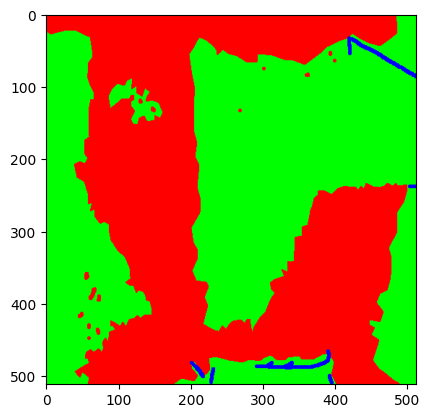

1e-05
[INFO] UpConv block 0 created.
[INFO] UpConv block 1 created.
[INFO] UpConv block 2 created.
[INFO] UpConv block 3 created.
[INFO] UpConv block 4 created.
[INFO] UpConv block 5 created.
Model name: model_2048_8_v8_u1
Path to the model: /content/gdrive/MyDrive/Models/U6_E_1201-F1_0.7134-IOU_0.6555.h5
Path to csv file: /content/gdrive/MyDrive/Metrics/model_2048_8_v8/results_model_2048_8_v8.csv


In [13]:
final_filters = 2048
model_version = "v8"
model_name = f"model_{final_filters}_{BATCH_SIZE}_{model_version}_u1"
update = "U2"
path_to_load = "/content/gdrive/MyDrive/Models/U6_E_1201-F1_0.7134-IOU_0.6555.h5"
path_to_csv = f"/content/gdrive/MyDrive/Metrics/{model_name[:-3]}/results_{model_name[:-3]}.csv"
image_number = 7

sample_image, sample_mask = get_example('/content/gdrive/MyDrive/dataset/RECORDS/tfrecords_v2_part_1.tfrec', 1)
plt.imshow(sample_mask)
plt.show()

learning_rate = 1e-5
print(learning_rate)

EPOCHS = 301
save_freq = 300
append_csv = True

if not os.path.isdir(os.path.dirname(path_to_csv)):
  os.makedirs(os.path.dirname(path_to_csv))
else:
  pass

model = build_unet(input_shape=(512, 512, 3),
                    filters=[2 ** i for i in range(5, int(np.log2(final_filters) + 1))],
                    batchnorm=False, transpose=False, dropout_flag=False)
model.load_weights(path_to_load)

# Loss function
loss_object = HybridLoss(_lambda_=1, _alpha=0.5, _beta=0.5, weights=[0.4, 2.2, 0.4], reduction=tf.keras.losses.Reduction.NONE)

def compute_loss(y_true, y_pred):
    per_example_loss = loss_object(y_true, y_pred)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=BATCH_SIZE)

# Metrics
train_iou = IOU(name="train_IoU", C=3)
train_f1score = F1Score(name="train_f1score", C=3)
test_iou = IOU(name="test_IoU", C=3)
test_f1score = F1Score(name="train_f1score", C=3)

# Optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')

def train_step(inputs):
    images, masks = inputs

    with tf.GradientTape() as tape:
      predictions = model(images)
      loss = compute_loss(masks, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_iou.update_state(masks, predictions)
    train_f1score.update_state(masks, predictions)

    return loss

def test_step(inputs):
    images, masks = inputs

    predictions = model(images)
    loss = loss_object(masks, predictions)

    test_iou.update_state(masks, predictions)
    test_f1score.update_state(masks, predictions)

print(f"Model name: {model_name}")
print(f"Path to the model: {path_to_load}")
print(f"Path to csv file: {path_to_csv}")


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 32  0           ['conv2d[0][0]']                 
                                )                                                             

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


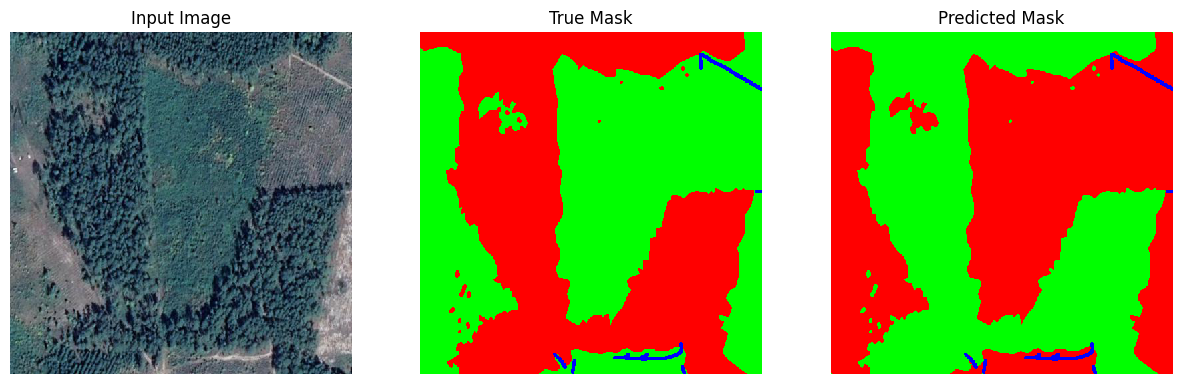

100%|██████████| 1/1 [01:14<00:00, 74.28s/it]


 Epoch 1, Loss Hybrid: 3.00173, Train IoU: 0.9964, Train F1_Score 0.9982, Test IoU: 0.9992, Test F1_Score 0.9996


In [ ]:
for epoch in tqdm(range(EPOCHS)):
    # BOUCLE D'ENTRAÎNEMENT
    total_loss = 0.0
    num_batches = 0

    for x in get_training_dataset():
        total_loss += train_step(x)
        num_batches += 1
    train_loss = total_loss / num_batches

    # BOUCLE DE TEST
    num_test_batches = 0
    for x in get_validation_dataset():
        num_test_batches += 1
        test_step(x)

    # AFFICHAGE
    template = ("Epoch {}, Loss Hybrid: {:.5f}, "
                "Train IoU: {:.4f}, Train F1_Score {:.4f}, "
                "Test IoU: {:.4f}, Test F1_Score {:.4f}")

    # clear_output(wait=True)
    show_predictions()
    print('\n', template.format(epoch + 1,
                          train_loss,
                          train_iou.result() / num_batches,
                          train_f1score.result() / num_batches,
                          test_iou.result() / num_test_batches,
                          test_f1score.result() / num_test_batches))

    train_iou.reset_states()
    train_f1score.reset_states()
    test_iou.reset_states()
    test_f1score.reset_states()

In [ ]:
model.save(f"/content/gdrive/MyDrive/Models/TPU/{model_name}.h5")

### Model Evaluation

In [14]:
# img = "221.png"
# img = "105.png"
img = "233.png"

1/1 [==============================] - 11s 11s/step


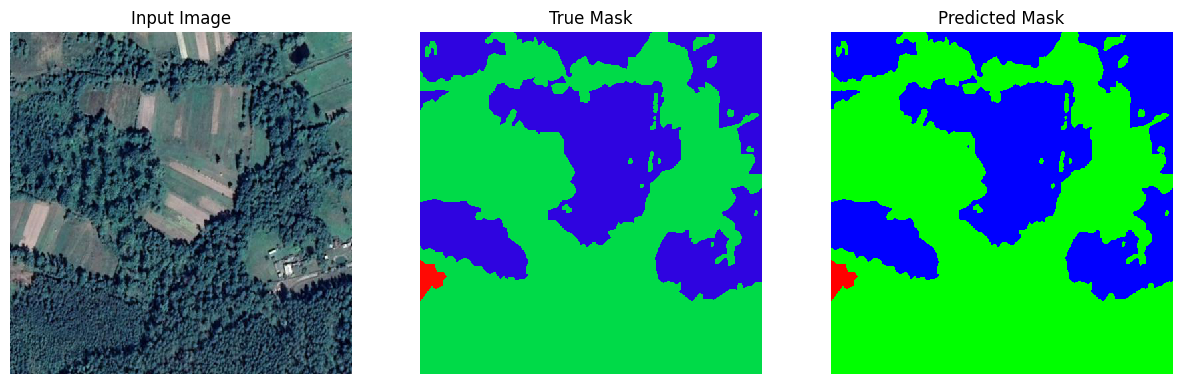

In [15]:
sample_mask = np.asarray(PIL.Image.open(f'/content/gdrive/MyDrive/dataset/data/data_shaffled_8_04_2021/masks/{img}'))
sample_image = np.asarray(PIL.Image.open(f'/content/gdrive/MyDrive/dataset/data/data_shaffled_8_04_2021/images/{img}'))
show_predictions()

1/1 [==============================] - 6s 6s/step


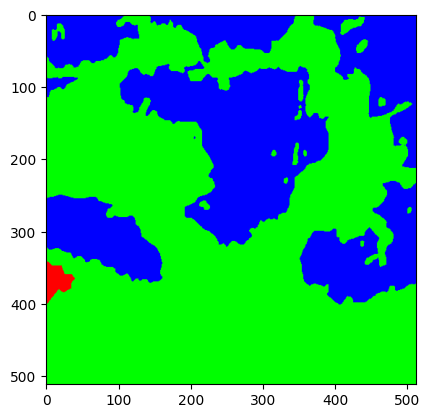

In [16]:
sample_image = np.asarray(PIL.Image.open(f'/content/gdrive/MyDrive/dataset/data/data_shaffled_8_04_2021/images/{img}'))
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
prediction_class1 = np.copy(prediction[..., 0]) # Forest
prediction_class2 = np.copy(prediction[..., 1]) # Deforest
prediction[..., 0] = prediction_class2 # RED - Deforest
prediction[..., 1] = prediction_class1 # GREEN - Forest
plt.imshow(prediction)

In [17]:
def compute_percentage(image):
    plt.imsave('prediction.png', image)
    image = cv2.imread('prediction.png')
    os.remove('prediction.png')
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    green_lower = np.array([0, 128, 0], dtype=np.uint8)
    green_upper = np.array([100, 255, 100], dtype=np.uint8)
    green_mask = cv2.inRange(image_rgb, green_lower, green_upper)

    green_pixel_count = np.count_nonzero(green_mask)
    total_pixel_count = image.shape[0] * image.shape[1]
    percentage_green = (green_pixel_count / total_pixel_count) * 100

    return percentage_green

In [24]:
def show_average_percentage(image):
    percentage_green = compute_percentage(image)
    size = [percentage_green / 100, (100 - percentage_green) / 100]
    percents = [str(round(i*100, 2))+"%" for i in size]
    names = [f"Forest, {percents[0]}", f"Deforestation, {percents[1]}"]
    plt.figure(figsize=(12, 10))
    my_circle = plt.Circle((0, 0), 0.6, color='white')
    custom_colors = [(196/255, 135/255, 81/255), (65/255, 166/255, 28/255)]

    if size[0] <= .5:
        custom_colors = [(65/255, 166/255, 28/255), (196/255, 135/255, 81/255)]

    cmap = ListedColormap(custom_colors)
    plt.title("Average percentage of class area", fontsize=20)
    plt.pie(size, labels=names, colors=cmap(size), textprops={'fontsize': 16})
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.savefig("Average_percentage_of_class_area_per_image.png")
    plt.show()

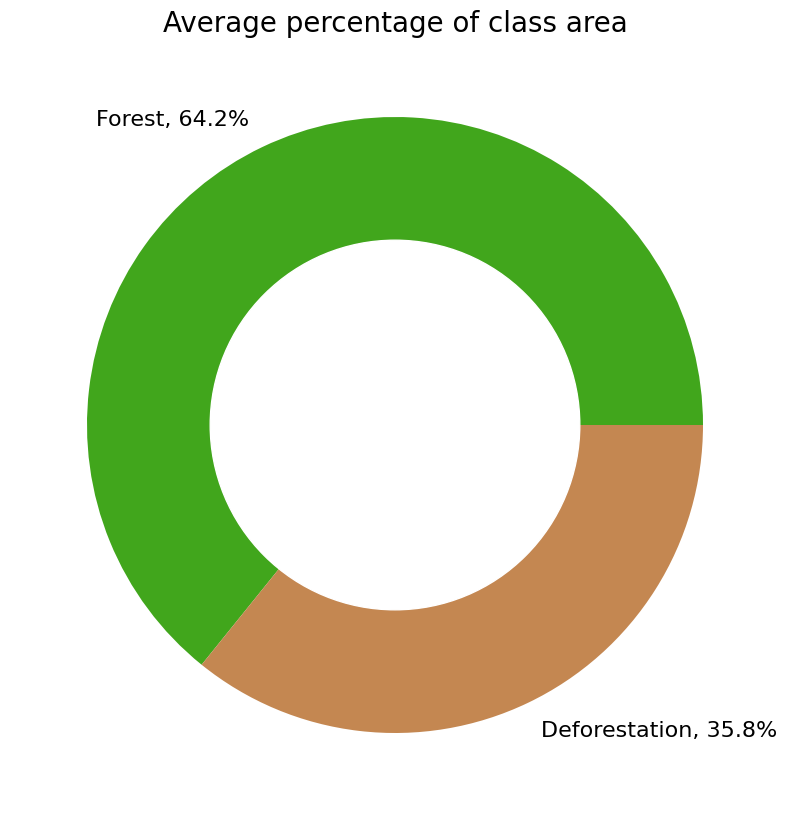

In [25]:
show_average_percentage(prediction)

In [34]:
def compute_carbon_expectation(image):
    '''
    7px de l'image correspond 4.5m
    1.5 px/m
    Dimension de l'image 512 px : 512 px
    Surface totale de l'image = 512² = 262144
    SurfaceVerte en pixels  = pourcentageVerte  * 262144
    surfaceVerte m² = surfaceVerte px² / (1.5 px/m)²
    En moyenne x kg de CO2 sont absorbés par 10000 m² de forêt et par an avec 25 tonnes < x < 35 tonnes
    Donc (x * surfaceVerte m²) / 10000 nous permet d'avoir une approximation de la quantité d'absortion de la forêt de l'image par an
    '''
    percentage_green = compute_percentage(image)
    total_pixels = image.shape[0] * image.shape[1]
    surface_verte_pixels = (percentage_green / 100) * total_pixels
    surface_verte_metres_carres = surface_verte_pixels / 2.25

    # On prend une valeur aleatoire entre 25 et 35 tonnes de CO2 par hectares et par an
    rand = random.randrange(25000, 35001)

    absorption_carbone_kg_an = round((rand * surface_verte_metres_carres) / 10000, 2)

    return absorption_carbone_kg_an

In [38]:
p = compute_carbon_expectation(prediction)
print(f'{p} kg par an.')
print(f'{round(p/1000, 2)} tonnes par an.')

198347.98 kg par an.
198.35 tonnes par an.


In [28]:
def tree_count(image):
    '''
    7px de l'image correspond 4.5m
    1.5 px/m
    Dimension de l'image 512 px : 512 px
    Surface totale de l'image = 512² = 262144
    SurfaceVerte en pixels  = pourcentageVerte  * 262144
    surfaceVerte m² = surfaceVerte px² / (1.5 px/m)²
    En moyenne le diamètre de la couronne des arbres de forêts varie entre 10 et 13m
    Donc (30000 kg * surfaceVerte m²) / 10000 nous permet d'avoir une approximation du nombre d'arbres de la forêt de l'image
    '''
    percentage_green = compute_percentage(image)
    total_pixels = image.shape[0] * image.shape[1]
    surface_verte_pixels = (percentage_green / 100) * total_pixels
    surface_verte_metres_carres = surface_verte_pixels / 2.25

    rand = random.randint(10, 13)
    tree_area = (rand / 2) * np.pi

    tree_number = int(surface_verte_metres_carres / tree_area)

    return tree_number

In [27]:
print(f'{tree_count(prediction)} arbres.')

4328 arbres.
